In [ ]:
import arc


In [3]:
# Configure the matplotlib graphics library and configure it to show
# figures inline in the notebook

%matplotlib inline
import matplotlib.pyplot as plt  # Import library for direct plotting functions
import numpy as np               # Import Numerical Python
from IPython.display import display, HTML #Import HTML for formatting output

# NOTE: Uncomment following lines ONLY if you are not using installation via pip
# import sys, os
# rootDir = '/path/to/arc/directory' # e.g. '/Users/Username/Desktop/ARC-Alkali-Rydberg-Calculator'
# sys.path.insert(0,rootDir)
# import sys, os
# sys.path.insert(0,"..")

import arc
from arc import *                 #Import ARC (Alkali Rydberg Calculator)
from scipy.constants import c, hbar
from scipy.constants import k as kb

In [ ]:
print("asdf")

In [4]:
class CesiumM(Cesium): 
    def __init__(self):
        self.atom = Cesium()
        self.eV2Hz = 2.417989242E14
        
    def findState(States, F, mf): 
        ind = np.intersect1d(np.where(States[1] == F),  np.where(States[2] == mf))
        if len(ind) > 1:
            return "Error"
        Energy = States[0]

        return Energy[0, ind[0]], ind[0]
    def Energy(self, n, l, j, f, mF, B): 
        States = self.atom.breitRabi(n, l, j, np.array([B]))
        return   CesiumM.findState(States, f, mF)[0] + self.atom.getEnergy(n, l, j)*self.eV2Hz 
    def getw0(self, stateI, stateF, B):
        return self.Energy(*stateF, B)  - self.Energy(*stateI, B) 
    def getSaturationIntensity(self, stateI, stateF):
        return self.atom.getSaturationIntensity(*stateI, *stateF)
    def getTransitionRate(self, stateI, stateF):
        return self.atom.getTransitionRate(*stateF[0:3], *stateI[0:3])
class Light:
    def __init__(self, stateI, stateF, delw, I, B):
        atom = CesiumM()
        self.mass = 2.2E-25
        self.w0 = atom.getw0(stateI, stateF,B)
        self.wavelength = c/(self.w0)

        self.k = 2*np.pi/self.wavelength
        self.delw = delw
        self.Isat = atom.getSaturationIntensity(stateI, stateF)
        self.s0  = I/self.Isat
        self.gamma = atom.getTransitionRate(stateI, stateF)
        
    def get_scatteringrate(self): 
        return self.s0*self.gamma/2*1/(1 + self.s0 + (2*self.delw/self.gamma)**2)
    def scatteringw_v(self, v):
        return self.s0*self.gamma/2*1/(1 + self.s0 + (2*(self.delw + self.k*v)/self.gamma)**2)
    def get_scatteringForce(self):
        return hbar*self.k*self.get_scatteringrate()
    def get_Erec(self):
        return 4*hbar*(hbar*self.k**2/(2*self.mass))*self.get_scatteringrate()
    def get_alpha(self):
        return 8*hbar*self.k**2*self.delw*self.s0/(self.gamma*(1 + self.s0 + (2*self.delw/self.gamma)**2)**2) 
    def get_Edop(self): # Edop/T
        return self.get_alpha()*kb/self.mass
    def get_Fdop(self, vel):
        return hbar*self.k*(self.scatteringw_v(-vel) - self.scatteringw_v(vel))
    def get_EPGC(self):
        return hbar*self.k**2 *(self.delw*self.gamma)/(5*self.gamma**2 + 4*self.delw**2)
    def get_heatingPower(self):
        return kb*(hbar*self.k)**2/(self.mass*kb)*self.get_scatteringrate()
atom = CesiumM()
Bf = 860E-4
print( atom.Energy(6, 0, 1/2, 4, 4, Bf) - atom.Energy(6, 0, 1/2, 3, 3, Bf) )


11358926874.375


In [6]:
Isat

11.023700310506518

Proof for doppler cooling


852.3534826097157


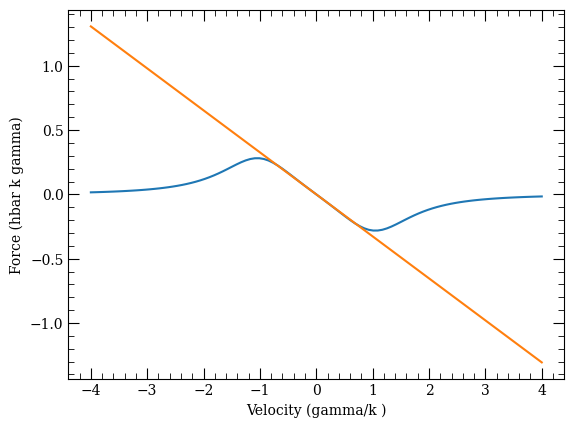

In [5]:

stateF = (6, 1, 1.5, 5, 5) 
stateI = (6, 0, 0.5, 4, 4)
B = 866E-4
a = Light(stateI, stateF, 10E6, 1, B)
print(a.wavelength*1E9)
w0_i = a.w0
k_i = a.k 
gamma = a.gamma
Isat = a.Isat

velocities = np.linspace(-4, 4, 100)
a2 = Light(stateI, stateF, -gamma, 2*Isat, B)
Fdop = a2.get_Fdop(velocities*gamma/k_i)
plt.plot(velocities, Fdop/(hbar*k_i*gamma))
plt.plot(velocities, (velocities*gamma/k_i*a2.get_alpha())/(hbar*k_i*gamma))
plt.ylabel('Force (hbar k gamma)')
plt.xlabel('Velocity (gamma/k )')
plt.show()

1.279904167866556e-06
9.413051816584724e-07
8.227955364856433e-07


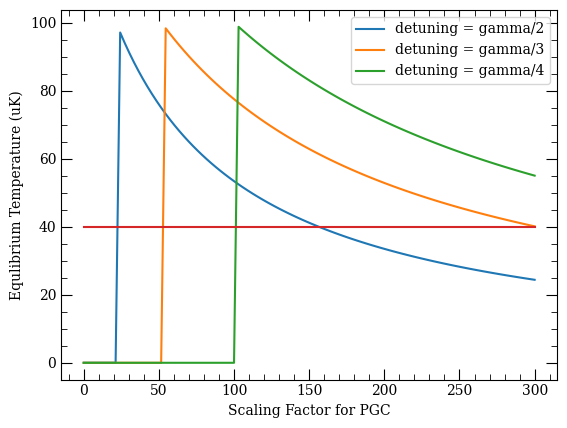

(81.64405227947059, 1671)


In [24]:
from numba import njit

@njit
def equilibrate(T, Erec, Edopp_T, EPGC_T, dt, maxIters, tol=1E-10):
    Ti = T
    success = False
    for i in range(int(maxIters)):
        Tf = Ti + dt*(Erec +  Ti*(Edopp_T + EPGC_T))/kb
        if abs(Tf - Ti) <  tol:
            success = i
            break
        if Ti > 100E-6:
            success = False
            break
        Ti = Tf
    return Ti*1E6, success

B = 866E-4
frac = np.arange(2, 5, 1)
for f in frac: 
    a = Light(stateI, stateF, -gamma/f, 0.1*Isat, B)
    Erec = a.get_Erec()
    Edopp_T = a.get_Edop()
    EPGC_T = a.get_EPGC() 
    T = 10E-6; 
    dt = 1/a.get_scatteringrate()
    print(dt)
    maxIters = 1E7


    const = np.linspace(0, 300, 100)
    eqTemp = []
    for c_i in const: 
        temp, s = equilibrate(T, Erec, Edopp_T, c_i*EPGC_T, dt, maxIters)
        if s:
            eqTemp.append(temp)
        else:
            eqTemp.append(0)
    plt.plot(const, eqTemp, label=f'detuning = gamma/{f}')
    
plt.legend()
plt.plot(const, np.ones(len(const))*40)
plt.xlabel('Scaling Factor for PGC')
plt.ylabel('Equlibrium Temperature (uK)')
plt.show()

print(equilibrate(T, Erec, Edopp_T, 155*EPGC_T, dt, maxIters))

52.09154780831894
852.3564199070158
14.000099394343279


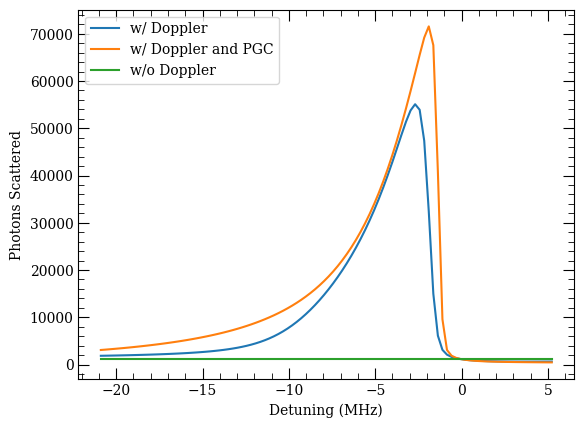

In [25]:
from joblib import Parallel, delayed
from numba import njit
mK2J = kb*1E-3
J2Mhz = 1/(hbar*2*np.pi)*1E-6
B = 0
stateF = (6, 1, 1.5, 5, 5) 
stateI = (6, 0, 0.5, 4, 4)
Trap_depthz = 2.5*mK2J
TrapParam = {"T": 10E-6, "U0": Trap_depthz}
print(Trap_depthz*J2Mhz)
def numOfPhotons(stateI, stateF, det, s, B, trapParam, Doppler=True, PGC = True, imaging_time = None):
    args  = []  
    T = TrapParam["T"]
    U0 = trapParam["U0"]
    maxIters = 1E7
    const = 154
    
    for d in det: 
        a = Light(stateI, stateF, d, s, B)
        Erec = a.get_Erec()
        Edopp_T = a.get_Edop() if Doppler else 0
        EPGC_T = const*a.get_EPGC() if PGC else 0 
        dt = 1/a.get_scatteringrate()
        
        
#        print(equilibrate(T, Erec, Edopp_T, EPGC_T, dt, maxIters))
        
        if imaging_time: 
            args.append([T, Erec, Edopp_T, EPGC_T, dt, U0, imaging_time/dt])
        else: 
            args.append([T, Erec, Edopp_T, EPGC_T, dt, U0, maxIters])

    photons = Parallel(n_jobs=8)(delayed(survival)(*arg) for arg in args)

    return photons



@njit
def survival(T, Erec, Edopp_T, EPGC_T,  dt, U0, maxIters, tol= 1E-3):
    P = 1
    numOfPhotons = 0 
    for i in range(int(maxIters)):
        T =  T + dt*(Erec + (Edopp_T + EPGC_T)*T)/kb #
        P = P*(1 - np.exp(-U0/(kb*T)))
        if P < tol:
            break
        numOfPhotons += P
    return numOfPhotons

a = Light(stateI, stateF, 10E6, 1, B)
print(a.wavelength*1E9)
w0_i = a.w0
gamma = a.gamma
Isat = a.Isat

detuning = gamma*np.linspace(-4,1,  100)
print(1.27*Isat)
IT = 10E-3
Inten = 1.2424828282828282*Isat
photonsWD = numOfPhotons(stateI, stateF, detuning,Inten, B, TrapParam, PGC = False, imaging_time = IT)
photonsWDPGC = numOfPhotons(stateI, stateF, detuning, Inten, B, TrapParam, PGC = True, imaging_time = IT)

photonsWOD = numOfPhotons(stateI, stateF, detuning,Inten, B, TrapParam, Doppler = False, PGC = False, imaging_time = IT)

plt.plot(detuning*1E-6/(2*np.pi), photonsWD, label='w/ Doppler')
plt.plot(detuning*1E-6/(2*np.pi), photonsWDPGC, label='w/ Doppler and PGC')
plt.plot(detuning*1E-6/(2*np.pi), photonsWOD, label='w/o Doppler')
plt.legend()
plt.ylabel('Photons Scattered')
plt.xlabel('Detuning (MHz)')
plt.show()


852.3564199070158


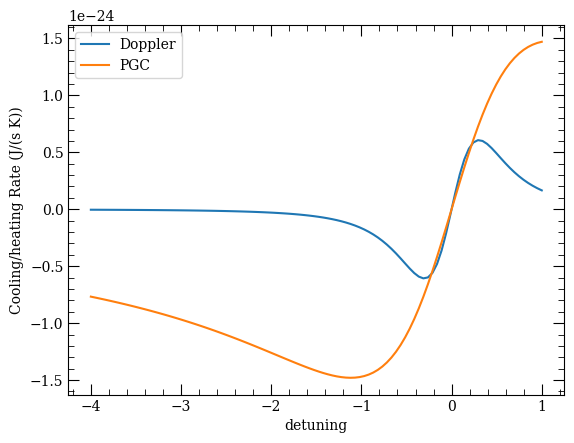

In [169]:
def paramScan(stateI, stateF, det, s, B, trapParam, Doppler=True, PGC = True, imaging_time = None):
    args  = []  
    T = TrapParam["T"]
    U0 = trapParam["U0"]
    maxIters = 1E7
    const = 154
    
    param = []
    for d in det: 
        a = Light(stateI, stateF, d, s, B)
        Erec = a.get_Erec()
        Edopp_T = a.get_Edop() if Doppler else 0
        EPGC_T = const*a.get_EPGC() if PGC else 0 
        dt = 1/a.get_scatteringrate()
        param.append([Erec, Edopp_T, EPGC_T])
        
    
    return param

a = Light(stateI, stateF, 10E6, 1, B)
print(a.wavelength*1E9)
w0_i = a.w0
gamma = a.gamma
Isat = a.Isat
detuning = gamma*np.linspace(-4,1,  100)
param = paramScan(stateI, stateF, detuning, 0.1*Isat, B, TrapParam, PGC = True, imaging_time = IT)
params = np.transpose(np.array(param))
Temp = 15E-6
#plt.plot(detuning/gamma, params[0, :]/(2*np.pi))
plt.plot(detuning/gamma, params[1, :]*Temp, label='Doppler')
plt.plot(detuning/gamma, params[2, :]*Temp, label='PGC')
plt.xlabel('detuning')
plt.ylabel('Cooling/heating Rate (J/(s K))')
plt.legend()
plt.show()

In [182]:
detuning = gamma*np.linspace(-2,0,  100)
trapDepthz = np.linspace(0.6, 4, 100)

maxPhotons = []
maxPhotons_PGC = []
associatedDet = []
associatedDet_PGC = []

for trapp in trapDepthz:
    Trap_depthz_i = trapp*mK2J
    TrapParam_i = {"T": 10E-6, "U0": Trap_depthz_i} 
    photonsWD = numOfPhotons(stateI, stateF, detuning, 0.1*Isat, B, TrapParam_i, PGC = False, imaging_time = IT)
    photonsWDPGC = numOfPhotons(stateI, stateF, detuning, 0.1*Isat, B, TrapParam_i, PGC = True, imaging_time = IT)

    maxPhotons.append( max(photonsWD))
    maxPhotons_PGC.append(max(photonsWDPGC))
    associatedDet_PGC.append(detuning[np.argmax(np.array(photonsWDPGC))])
    associatedDet.append(detuning[np.argmax(np.array(photonsWD))])


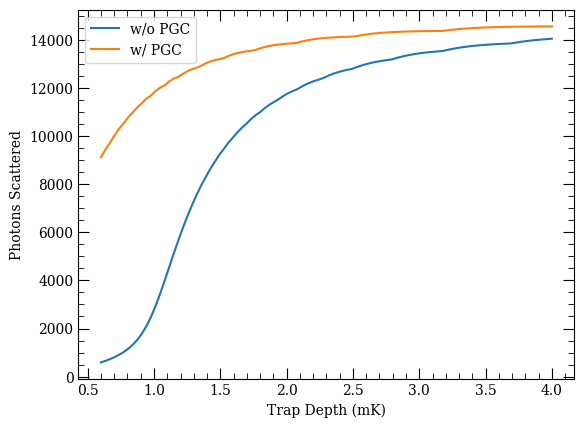

In [186]:
plt.plot(trapDepthz, maxPhotons, label='w/o PGC')
plt.plot(trapDepthz,maxPhotons_PGC, label='w/ PGC')
plt.xlabel('Trap Depth (mK)')
plt.ylabel('Photons Scattered')
plt.legend()
plt.show()

In [21]:
detuning = gamma*np.linspace(-2,0,  100)
s = np.linspace(0.0001, 3, 100)
maxPhotons = []
associatedDet = []
for s_i in s: 
    photonsWD = numOfPhotons(stateI, stateF, detuning, s_i*Isat, B, TrapParam, PGC = False, imaging_time = IT)
    maxPhotons.append( max(photonsWD))
    associatedDet.append(detuning[np.argmax(np.array(photonsWD))])


NameError: name 'Isat' is not defined

4.0 1.2189563503491011e-07


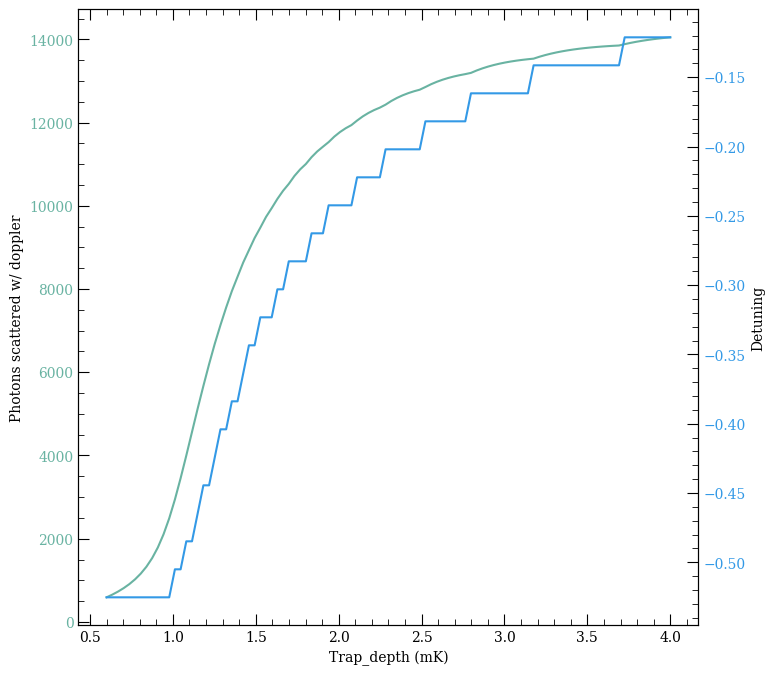

In [181]:
COLOR_PHOT = "#69b3a2"
COLOR_DET = "#3399e6"

fig, ax1 = plt.subplots(figsize=(8, 8))
ax2 = ax1.twinx()

ax1.plot(trapDepthz, maxPhotons, color=COLOR_PHOT)

ax2.plot(trapDepthz, np.array(associatedDet)/gamma, color=COLOR_DET)

ax1.set_xlabel('Trap_depth (mK)')
ax2.set_ylabel('Detuning')
ax1.set_ylabel('Photons scattered w/ doppler')
ax1.tick_params(axis="y", labelcolor=COLOR_PHOT)
ax2.tick_params(axis="y", labelcolor=COLOR_DET)
ind = np.argmax(np.array(maxPhotons))
print(trapDepthz[ind], trapDepthz[ind]/gamma)


1.2424828282828282 -0.505050505050505


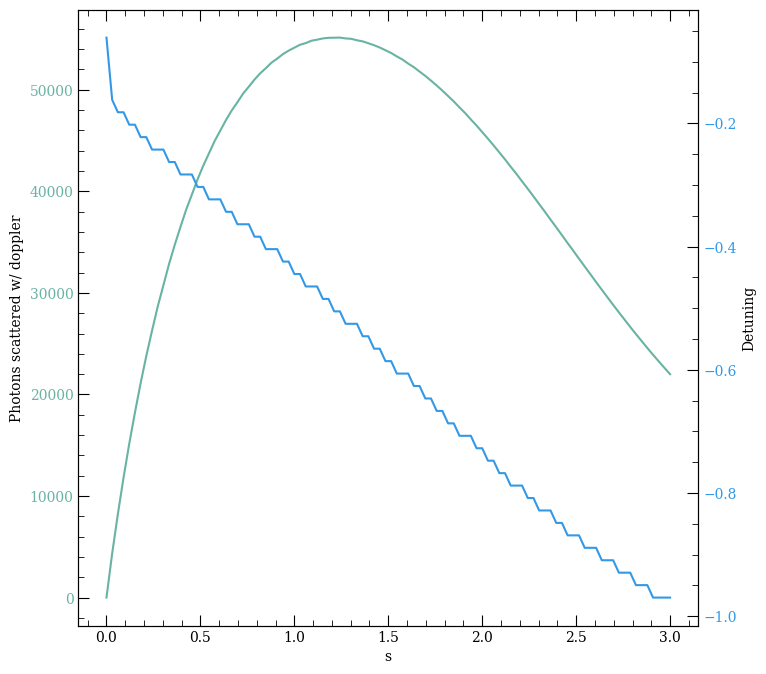

In [22]:
COLOR_PHOT = "#69b3a2"
COLOR_DET = "#3399e6"

fig, ax1 = plt.subplots(figsize=(8, 8))
ax2 = ax1.twinx()

ax1.plot(s, maxPhotons, color=COLOR_PHOT)
ax2.plot(s, np.array(associatedDet)/gamma, color=COLOR_DET)

ax1.set_xlabel('s')
ax2.set_ylabel('Detuning')
ax1.set_ylabel('Photons scattered w/ doppler')
ax1.tick_params(axis="y", labelcolor=COLOR_PHOT)
ax2.tick_params(axis="y", labelcolor=COLOR_DET)
ind = np.argmax(np.array(maxPhotons))
print(s[ind], associatedDet[ind]/gamma)


J2khz = 1.509E24*1E6
B = 0
stateF_2 = (6, 1, 1.5, 4, 3)
stateF_1 = (6, 1, 1.5, 4, 3) 
stateI = (6, 0, 0.5, 3, 3)
atom = CesiumM()
w0_ref = (atom.getw0(stateI, stateF_2,B) + atom.getw0(stateI, stateF_1,B))/2




Proof for the scattering rate

In [ ]:
J2khz = 1/(hbar*2*np.pi)*1E-3
print(J2khz)
B = 866E-4
stateF = (6, 1, 1.5, 5, 5) 
stateI = (6, 0, 0.5, 4, 4)
#w0 = atom.Energy(6, 1, 1.5, 5, 5, B)  - atom.Energy(6, 0, 0.5, 4, 4, B) 

a = Light(stateI, stateF, 10E6, 1, B)
w0_i = a.w0
gamma = a.gamma
Isat = a.Isat
detuning = gamma*np.linspace(-10, 10, 100)
s0 = [0.1, 1.0, 10, 100]
for s in s0:
    dvec = []
    for d in detuning: 
        a = Light(stateI, stateF, d, Isat*s, B)
        dvec.append(a.get_scatteringrate()/a.gamma)
    plt.plot(detuning/gamma, dvec, label=f's0 = {s}')
plt.legend()
plt.xlabel('Detuning')
plt.ylabel('Scattering_rate/Tau')
plt.show()
# 150, 30 kHz 0.5 ms - 10 ms


In [ ]:
(w0_ref - w0_i)

In [ ]:
print(w0_i*1E-9)
print(w0_ref*1E-9)

w0_i

In [ ]:
%matplotlib widget

In [ ]:
Our_power = 6
mW_um2W_cm = 1E-3*(1E4)**2
o_p = Our_power/(np.pi*500**2)*mW_um2W_cm
s0_act = o_p/Isat

detunings = gamma*np.linspace(0.5, 1.5,10)
print(gamma)
for det in detunings:
    s0s = np.linspace(0, 2*0.09, 10)
    Heating_rate = []
    Photons_scattered = []
    for s in s0s:
        a = Light(stateI, stateF, det, s*Isat, B)
        Heating_rate.append(a.get_heatingPower()*J2Mhz)
        Photons_scattered.append(a.get_scatteringrate())
    plt.plot(s0s, Heating_rate, label=f'{round(det*1E-6, 1)} Mhz, {round(det/gamma, 1)} Tau')
    #plt.plot(s0s, Photons_scattered, label=f'{round(det*1E-6, 1)} Mhz, {round(det/gamma, 1)} Tau')
plt.axvline(x = s0_act, color = 'b', label = 'axvline - full height')
plt.legend()
plt.xlabel('s0')
plt.ylabel('Mhz/ms')
plt.show()

plt.legend()
plt.xlabel('s0')
plt.ylabel('Photons Scattered')
plt.show()

In [26]:
Isat

11.023700310506518

In [ ]:
14*0.7*.7

In [ ]:
#beam configuration
